# Librerias

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt

# Data Drifting Generator

En el presente notebook simulamos cambios en la distribución del dataset original con el fin de medir el impacto en el performance del modelo.

# Conjunto de datos base (Baseline)

Para la simulación de *data drifting*, se define como conjunto de datos base una versión del dataset únicamente con correcciones estructurales mínimas. Esta decisión busca mantener la distribución original de los datos sin introducir valores artificiales que puedan alterar la evaluación del *drift*.

El conjunto de datos base se obtiene aplicando exclusivamente los siguientes procesos al conjunto de datos original:

1. Normalización de texto: Conversión a mayúsculas y eliminación de espacios en blanco en las columnas `[ "Performance", "Gender", "Caste", "coaching", "time", "Class_ten_education", "twelve_education", "medium", "Class_ X_Percentage", "Class_XII_Percentage", "Father_occupation", "Mother_occupation", "mixed_type_col"]`.
2. Unificación de representaciones de valores nulos: Homogeneización de strings como "NAN", "NULL" o "NONE" a valores nulos.
3. Homogeneización de nombres de columnas: Renombrado de columnas con nombres mal formados ("Class_ X_Percentage" a "Class_X_Percentage").

De esta forma logramos mantener la naturaleza original de los datos en el dataset pero agregando más estructura.


# Conjunto de datos al que se le simula drifting

Derivado de la sección 'Conjunto de datos base (Baseline)' se establece que al conjunto de datos al que se le aplicará drifting, es el conjunto de datos original,  después de habersele aṕlicado pero las transformaciones definidas en 'Conjunto de datos base (Baseline)'.

Para lograr este cometido, se ha desarrolado el script de python:

    `src/data/baseline_generator.py`

Este script toma el dataset original, aplica las transformaciones definidas en la sección 'Conjunto de datos base (Baseline)' y guarda el resultado en la ruta:

    `data/baseline/student_performance_baseline.csv`

## Lectura del conjunto de datos base

Consideraciones importantes:

* El conjunto de datos original y por lo tanto el conjunto de datos base, están formados únicamente por variables categóricas.
* A lo largo del proyecto se planteó como variable objetivo la variable 'Performance'.
* El modelo seleccionado para el flujo de predicción fue registrado usando MLFlow y sus artifacts se encuentran en la ruta:
    `data/mlflow/models/mlflow-student-performance-experiment_CatBoost/`
* El modelo, corresponde a un modelo del tipo CatBoost, pues se planteó el problema como un problema de clasificación ordinal.

In [2]:
baseline_df = pd.read_csv("../data/baseline/student_performance_baseline.csv")
baseline_df.head()

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,EXCELLENT,MALE,GENERAL,NO,ONE,SEBA,AHSEC,ENGLISH,EXCELLENT,EXCELLENT,DOCTOR,OTHERS
1,EXCELLENT,MALE,OBC,WA,TWO,SEBA,AHSEC,OTHERS,EXCELLENT,EXCELLENT,SCHOOL_TEACHER,HOUSE_WIFE
2,EXCELLENT,MALE,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,EXCELLENT,EXCELLENT,BUSINESS,HOUSE_WIFE
3,EXCELLENT,MALE,GENERAL,WA,ONE,SEBA,AHSEC,OTHERS,EXCELLENT,EXCELLENT,SCHOOL_TEACHER,SCHOOL_TEACHER
4,EXCELLENT,MALE,GENERAL,OA,TWO,SEBA,CBSE,ENGLISH,EXCELLENT,EXCELLENT,COLLEGE_TEACHER,HOUSE_WIFE


In [3]:
print(baseline_df.describe().T.to_markdown())

|                      |   count |   unique | top        |   freq |
|:---------------------|--------:|---------:|:-----------|-------:|
| Performance          |     666 |        4 | GOOD       |    210 |
| Gender               |     666 |        2 | MALE       |    355 |
| Caste                |     666 |        4 | GENERAL    |    329 |
| coaching             |     666 |        3 | WA         |    449 |
| time                 |     666 |        6 | TWO        |    368 |
| Class_ten_education  |     666 |        3 | SEBA       |    396 |
| twelve_education     |     666 |        3 | AHSEC      |    368 |
| medium               |     666 |        3 | ENGLISH    |    536 |
| Class_X_Percentage   |     666 |        4 | EXCELLENT  |    511 |
| Class_XII_Percentage |     666 |        4 | EXCELLENT  |    398 |
| Father_occupation    |     666 |        8 | OTHERS     |    277 |
| Mother_occupation    |     666 |        9 | HOUSE_WIFE |    442 |


In [4]:
baseline_df.isnull().sum()

Performance             0
Gender                  0
Caste                   0
coaching                0
time                    0
Class_ten_education     0
twelve_education        0
medium                  0
Class_X_Percentage      0
Class_XII_Percentage    0
Father_occupation       0
Mother_occupation       0
dtype: int64

# Transformaciones de simulación de 'drifting'

## Escenario 1 — Cambio en la distribución de la variable objetivo (Performance)

**Planteamiento del escenario**  

En este escenario, la distribución de la variable objetivo (Performance) cambia significativamente respecto al conjunto de datos base. El escenario se caracteriza porque no hay cambios en las características (X), solo en la variable objetivo (y).

**Medición del drifting**  

La medición se realiza mediante métricas que comparan dos distribuciones categóricas:
* Chi-cuadrada (χ²): detecta si la distribución de categorías del target cambió significativamente.
* KL Divergence: mide la divergencia entre la distribución original y la nueva; cuanto mayor es, mayor es la diferencia.
* PSI (Population Stability Index): estándar industrial (finanzas, educación, riesgos) para detectar cambios en la población; PSI > 0.2 indica drift importante.

Estas métricas son adecuadas porque son:
* sensibles a pequeños cambios en proporciones,
* no requieren supuestos de normalidad,
* robustas aun con datos categóricos.

**Importancia en su medición**

Medir label shift es crítico porque:

* Afecta directamente el desempeño del modelo. Si un modelo fue entrenado en un mundo donde la mayoría era GOOD, y ahora hay más AVERAGE, las probabilidades predichas quedarán sesgadas.
* Puede generar decisiones erróneas. En un contexto educativo, podrías subestimar el riesgo académico si el modelo aún “cree” que la mayoría de estudiantes es GOOD.
* Es uno de los drifts más peligrosos, pues un cambio en la distribución de la variable objetivo altera la interpretación de métricas de desempeño, generando una falsa seguridad.

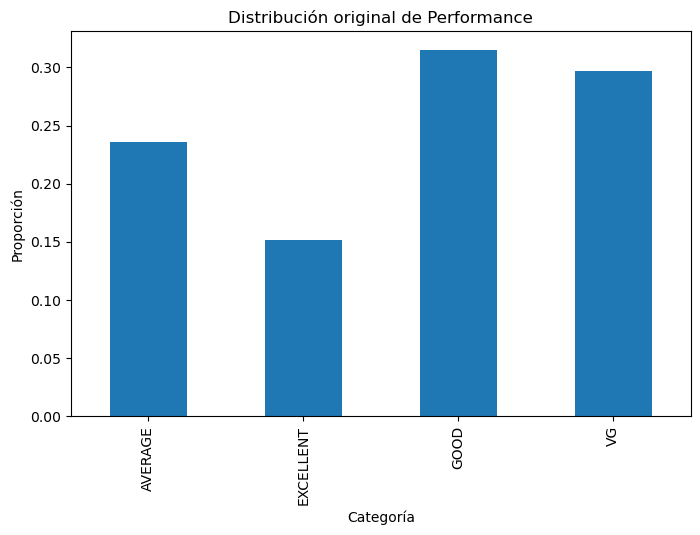

Performance
AVERAGE      0.235736
EXCELLENT    0.151652
GOOD         0.315315
VG           0.297297
Name: proportion, dtype: float64

In [5]:
plt.figure(figsize=(8,5))
baseline_df['Performance'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribución original de Performance")
plt.xlabel("Categoría")
plt.ylabel("Proporción")
plt.show()

baseline_df['Performance'].value_counts(normalize=True).sort_index()

### Simulación de drifting

In [6]:
# =======================================
# Simulación de Label Shift SIN cambiar el número de observaciones
# =======================================

df_drift_escenario_1 = baseline_df.copy()

# Nueva distribución objetivo para el drifting
new_distribution = {
    "GOOD": 0.20,
    "VG": 0.15,
    "AVERAGE": 0.55,
    "EXCELLENT": 0.10
}

# Aseguramos que sumen 1
assert sum(new_distribution.values()) == 1.0, "La distribución debe sumar 1"

# Número total de filas
n = len(df_drift_escenario_1)

# Generar nueva columna Performance reasignada aleatoriamente
np.random.seed(13)
df_drift_escenario_1["Performance"] = np.random.choice(
    list(new_distribution.keys()),
    size=n,
    replace=True,
    p=list(new_distribution.values()),
)

df_drift_escenario_1.to_csv("../data/drifted/raw/student_entry_performance_drifted_case_one.csv", index=False)

df_drift_escenario_1["Performance"].value_counts(normalize=True).sort_index()

Performance
AVERAGE      0.492492
EXCELLENT    0.105105
GOOD         0.213213
VG           0.189189
Name: proportion, dtype: float64

### Visualizacion comparativa de la distribución de 'Performance'

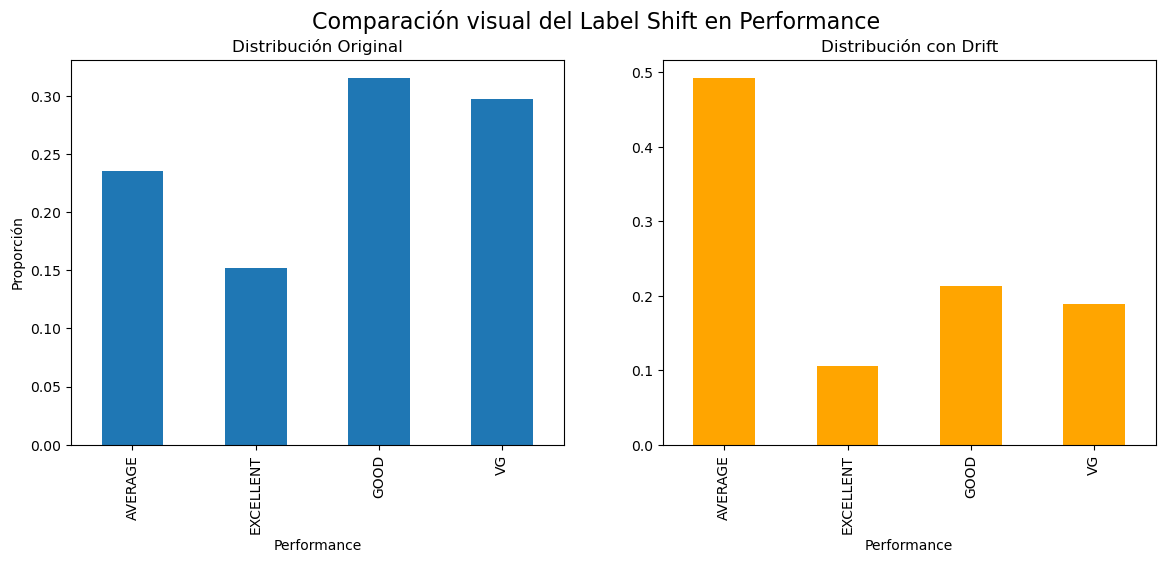

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

baseline_df['Performance'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[0])
ax[0].set_title("Distribución Original")
ax[0].set_ylabel("Proporción")

df_drift_escenario_1['Performance'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title("Distribución con Drift")

plt.suptitle("Comparación visual del Label Shift en Performance", fontsize=16)
plt.show()


### Estadisticas para diagnosticar el drifting

In [8]:
# Frecuencias
f_base = baseline_df['Performance'].value_counts(normalize=False).sort_index()
f_drift = df_drift_escenario_1['Performance'].value_counts(normalize=False).sort_index()

print("", f_base, "\n\n", f_drift)

 Performance
AVERAGE      157
EXCELLENT    101
GOOD         210
VG           198
Name: count, dtype: int64 

 Performance
AVERAGE      328
EXCELLENT     70
GOOD         142
VG           126
Name: count, dtype: int64


#### Chi-cuadrada

Para esta prueba, establecemos las hipótesis:

* Hipótesis Nula (H0): Las frecuencias observadas son iguales a las frecuencias esperadas.

* Hpótesis Alternativa (H1): Las frecuencias observadas no son iguales a las frecuencias esperadas.

Y para concluir a partir del `p-value`:

* Se rechaza H0 Si el `p-value` es menor que el nivel de significancia (α).
* No se rechaza H0 si el `p-value` es mayor o igual que el nivel de significancia.

Para todas nuestras pruebas establecemos:

* Nivel de significancia` α = 0.05`

In [9]:
# ---------------------------
# 1. Prueba Chi-cuadrada
# ---------------------------
chi2_stat, p_value = chisquare(f_obs=f_drift, f_exp=f_base, sum_check=False)

In [10]:
chi2_stat, p_value

(243.96412492932643, 1.3220131192976244e-52)

#### KL (Kullback–Leibler Divergence)

La Divergencia KL es una medida de distancia entre distribuciones que cuantifica cuánto se desvía la distribución de los datos con drift respecto al conjunto base. A diferencia de Chi-Cuadrada, no es una prueba de hipótesis, sino una métrica continua de disimilitud.

Aunque KL Divergence no es una prueba estadística como Chi Cuadrada, podemos interpretarla conceptualmente así:

* Hipótesis Nula (H0): No existe diferencia significativa entre la distribución original y la distribución con drift → la distancia KL ≈ 0.

* Hipótesis Alternativa (H1): La distribución con drift es diferente de la original → la distancia KL > 0.

No existe un umbral universal como tal, pero, usualmente se usa:

* KL Divergence < 0.01 → Distribuciones prácticamente idénticas
* KL Divergence 0.01 – 0.1 → Cambio pequeño
* KL DIvergence 0.1 – 0.25 → Cambio moderado
* KL Divergence > 0.25 → Cambio fuerte → drift evidente

La divergencia KL entre dos distribuciones P (drift) y Q (base) se define como:

$$
D_{KL}(P \parallel Q) = \sum_{i} P(i) \, \log\left(\frac{P(i)}{Q(i)}\right)
$$

Donde:
- $P(i)$ es la proporción de la categoría $i$ en el conjunto con drift.
- $Q(i)$ es la proporción de la categoría $i$ en el conjunto base.

Para evitar el computo de logaritmos en 0 o divisiones por 0, se añade a la ecuación un número pequeño. De ahí la forma en la que lo calculamos usando python con la siguiente celda de código.

In [11]:
# Distribuciones/Probabilidades
p_base = baseline_df['Performance'].value_counts(normalize=True).sort_index()
p_drift = df_drift_escenario_1['Performance'].value_counts(normalize=True).sort_index()

print("", p_base, "\n\n", p_drift)

 Performance
AVERAGE      0.235736
EXCELLENT    0.151652
GOOD         0.315315
VG           0.297297
Name: proportion, dtype: float64 

 Performance
AVERAGE      0.492492
EXCELLENT    0.105105
GOOD         0.213213
VG           0.189189
Name: proportion, dtype: float64


In [12]:
# ---------------------------
# 2. KL Divergence
# ---------------------------
kl = np.sum(p_drift * np.log((p_drift + 1e-10) / (p_base + 1e-10)))
kl

0.15538155762744887

#### PSI (Population Stability Index)

El PSI mide la estabilidad de una variable entre dos poblaciones, tampoco es una prueba de hipótesis, sino un índice de cambio estructural.

SImilar al KL Divergence, podemos interpretaor el cálculo para establecer hipótesis:

* Hipótesis Nula (H0): Las distribuciones son estables → PSI cercano a 0.
* Hipótesis Alternativa (H1):Las distribuciones son diferentes → PSI significativamente mayor que 0.

Criterios estándar de interpretación:

* PSI < 0.1	Estabilidad → No hay drift
* PSI 0.1 – 0.25	Cambios moderados → posible drift
* PSI ≥ 0.25	Cambios severos → drift fuerte

El PSI entre una distribución base Q y una distribución 'nueva' P se calcula como:

$$
PSI = \sum_{i} 
\left( P(i) - Q(i) \right) \,
\log\left(\frac{P(i)}{Q(i)}\right)
$$

Donde:
- $P(i)$: proporción de la categoría $i$ en los datos con drift.
- $Q(i)$: proporción de la categoría $i$ en los datos originales.

Para evitar el computo de logaritmos en 0 o divisiones por 0, se añade a la ecuación un número pequeño. De ahí la forma en la que lo calculamos usando python con la siguiente celda de código.

In [13]:
# ---------------------------
# 3. PSI
# ---------------------------
psi = np.sum((p_drift - p_base) * np.log((p_drift + 1e-10) / (p_base + 1e-10)))
psi

0.29504906733940345

#### Interpretación de los resultados

In [14]:
# ============================================================
# 6. INTERPRETACIÓN DE LOS RESULTADOS ESTADÍSTICOS
# ============================================================

print("==============================================")
print("Resultados de Pruebas de Drift")
print("==============================================")

print(f"Chi-Cuadrada (χ²): {chi2_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"KL Divergence: {kl:.4f} nats")
print(f"PSI: {psi:.4f}")

print("\n==============================================")
print("Interpretación de Chi-Cuadrada")
print("==============================================")

if p_value < 0.001:
    print("El p-value < 0.001 → Cambios extremadamente significativos en la distribución.")
elif p_value < 0.01:
    print("El p-value < 0.01 → Cambios muy significativos en la distribución.")
elif p_value < 0.05:
    print("El p-value < 0.05 → La distribución ha cambiado significativamente (drift detectado).")
else:
    print("El p-value ≥ 0.05 → No hay evidencia estadística fuerte de drift.")

    
print("\n==============================================")
print("Interpretación de KL Divergence")
print("==============================================")

if kl < 0.01:
    print("KL < 0.01 → Distribuciones prácticamente iguales.")
elif kl < 0.1:
    print("0.01 ≤ KL < 0.1 → Pequeño cambio detectable.")
elif kl < 0.25:
    print("0.1 ≤ KL < 0.25 → Cambio moderado en la distribución.")
else:
    print("KL ≥ 0.25 → Cambio fuerte → Drift significativo.")


print("\n==============================================")
print("Interpretación de PSI")
print("==============================================")

if psi < 0.1:
    print("PSI < 0.1 → No hay drift (estabilidad).")
elif psi < 0.25:
    print("0.1 ≤ PSI < 0.25 → Drift moderado detectado.")
else:
    print("PSI ≥ 0.25 → Drift severo (impacto fuerte en la distribución).")


print("\n==============================================")
print("Conclusión Global")
print("==============================================")

flags = 0
if p_value < 0.05: flags += 1
if kl >= 0.1: flags += 1
if psi >= 0.1: flags += 1

if flags == 0:
    print("No se detecta evidencia relevante de data drifting en la variable Performance.")
elif flags == 1:
    print("Se detecta una señal leve de data drifting.")
elif flags == 2:
    print("Hay alta probabilidad de data drifting (múltiples métricas lo indican).")
else:
    print("Drifting severo detectado → La distribución ha cambiado de manera significativa.")


Resultados de Pruebas de Drift
Chi-Cuadrada (χ²): 243.9641
p-value: 0.000000
KL Divergence: 0.1554 nats
PSI: 0.2950

Interpretación de Chi-Cuadrada
El p-value < 0.001 → Cambios extremadamente significativos en la distribución.

Interpretación de KL Divergence
0.1 ≤ KL < 0.25 → Cambio moderado en la distribución.

Interpretación de PSI
PSI ≥ 0.25 → Drift severo (impacto fuerte en la distribución).

Conclusión Global
Drifting severo detectado → La distribución ha cambiado de manera significativa.


### Evaluación del modelo en el conjunto de datos con drifting

Para esta sección hemos trabajado en el script:

    `src/feature/calculate_features.py`

En este script hemos desarrollado el proceso de cálculo de features a partir de un conjunto de datos de entrada, el objetivo es tomar datos 'crudos', por ejemplo, los datos crudos a los que se les aplicó data drift y obtener las features asociadas a estos.

Este paso es sumamente importante, pues el modelo entrenado durante el proyecto utilizó el conjunto de datos resultante del proceso de feature engineering, así que los mismos objetos de transformación generados durante el proceso de entrenamiento, deben ser usados en el pipeline de inferencia y por lo tanto en el pipeline de detección de drift.

EL script de python, una vez que fue ejecutado, generó el siguiente conjunto de datos:

    `data/drifted/feature/student_entry_performance_drifted_case_one_features.csv`

Este conjunto de datos será porcesado por el modelo con el fin de obtener las predicciones asociadas y evaluar el rendimiento.

In [15]:
df_drift_escenario_1_features = pd.read_csv("../data/drifted/features/student_entry_performance_drifted_case_one_features.csv")
df_drift_escenario_1_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,Performance
0,0.016112,-0.884263,-0.073889,-0.363668,-0.073740,0.521321,-0.435842,0.852277,-0.690682,-0.155186,-0.512798,-0.039825,-0.239179,-0.054696,-0.272755,-0.213795,0
1,1.365185,0.445794,-0.147527,-0.475469,0.300109,-0.828647,0.322018,0.235908,0.093331,0.147674,0.040158,0.033807,0.064337,-0.101863,0.146601,-0.019668,2
2,-0.728920,-0.128923,-1.217946,-0.817911,0.516215,-0.060720,0.098768,-0.088325,0.535611,0.068040,0.046508,0.142610,0.535463,-0.086709,0.259503,0.082996,0
3,1.553369,-0.762923,0.311647,0.056408,-0.372778,-0.623380,-0.049329,-0.271276,0.284213,0.009110,-0.072582,-0.069185,0.065247,-0.176186,-0.022449,-0.008908,3
4,-0.122090,-0.027806,-0.797853,-0.412268,-0.470477,0.341618,0.088702,-0.120244,-0.378445,-0.287364,-0.100373,-0.361468,0.616989,0.822618,0.195747,-0.459226,3


#### Cargamos el modelo

In [16]:
import mlflow
from mlflow.tracking import MlflowClient
from pathlib import Path
import os

# Configurar MLflow con ruta relativa al proyecto
# Buscamos la raíz del proyecto buscando la carpeta data/mlflow
current_dir = Path.cwd()
mlflow_dir = None

# Si estamos en la raíz o en notebooks/, buscamos data/mlflow
for search_dir in [current_dir, current_dir.parent]:
    potential_mlflow = search_dir / "data" / "mlflow"
    if potential_mlflow.exists():
        mlflow_dir = potential_mlflow
        break

if mlflow_dir is None:
    raise FileNotFoundError(
        f"No se encontró la carpeta data/mlflow. "
        f"Current directory: {current_dir}. "
        f"Ejecuta el notebook desde la raíz del proyecto o desde notebooks/"
    )

mlflow.set_tracking_uri(f"file:{mlflow_dir}")
print(f"📂 MLflow tracking URI: file:{mlflow_dir}")

# Nombre del experimento y modelo (configurables)
experiment_name = "mlflow-student-performance-experiment"
model_run_name = "LightGBM"  # Nombre del run del modelo

# Buscar el modelo más reciente usando MLflow Client
client = MlflowClient(tracking_uri=f"file:{mlflow_dir}")

# Obtener el experimento
experiment = mlflow.get_experiment_by_name(experiment_name)
if not experiment:
    raise ValueError(f"El experimento '{experiment_name}' no existe en MLflow.")

# Buscar el run más reciente del modelo LightGBM
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{model_run_name}'",
    order_by=["start_time DESC"],
    max_results=1,
)

if not runs:
    raise ValueError(f"No se encontró ningún run para el modelo '{model_run_name}' en el experimento '{experiment_name}'.")

best_run = runs[0]
run_id = best_run.info.run_id

print(f"✅ Encontrado modelo: {model_run_name}")
print(f"   Run ID: {run_id}")
print(f"   Métricas: RMSE={best_run.data.metrics.get('rmse', 'N/A'):.4f}, "
      f"QWK={best_run.data.metrics.get('quadratic_weighted_kappa', 'N/A'):.4f}")

# Intentar cargar el modelo desde diferentes posibles paths
# Nota: cuando se registra en Model Registry, se usa runs:/{run_id}/model
# pero cuando se guarda directamente, puede usar artifact_path=model_name
possible_paths = [
    "model",  # artifact_path usado al registrar en Model Registry (ver train_model.py línea 406)
    model_run_name,  # artifact_path=model_name usado al guardar directamente
]

model = None
model_uri = None

for artifact_path in possible_paths:
    try:
        test_uri = f"runs:/{run_id}/{artifact_path}"
        model = mlflow.pyfunc.load_model(test_uri)
        model_uri = test_uri
        print(f"✅ Modelo cargado desde: {test_uri}")
        break
    except Exception as e:
        continue

# Si no funcionó, intentamos listar los artifacts disponibles
if model is None:
    try:
        # Listar artifacts del run para encontrar el path correcto
        artifacts = client.list_artifacts(run_id)
        artifact_paths = [a.path for a in artifacts]
        
        print(f"\n📋 Artifacts disponibles en el run:")
        for path in artifact_paths:
            print(f"   - {path}")
        
        # Buscar el primer artifact que contenga un modelo
        for artifact in artifacts:
            # Intentar cargar si es un directorio que podría contener un modelo
            if artifact.is_dir:
                try:
                    test_uri = f"runs:/{run_id}/{artifact.path}"
                    model = mlflow.pyfunc.load_model(test_uri)
                    model_uri = test_uri
                    print(f"✅ Modelo cargado desde: {test_uri}")
                    break
                except:
                    continue
        
        if model is None:
            # Último intento: buscar en el Model Registry
            registered_model_name = f"{experiment_name.replace(' ', '_')}_{model_run_name}"
            try:
                # Intentar cargar la versión más reciente del modelo registrado
                model_uri = f"models:/{registered_model_name}/latest"
                model = mlflow.pyfunc.load_model(model_uri)
                print(f"✅ Modelo cargado desde Model Registry: {model_uri}")
            except Exception as registry_error:
                raise ValueError(
                    f"No se pudo cargar el modelo desde ningún path.\n"
                    f"  - Artifacts disponibles en el run: {artifact_paths if 'artifact_paths' in locals() else 'Ninguno'}\n"
                    f"  - Intentado Model Registry: {registered_model_name}\n"
                    f"  - Error: {registry_error}\n"
                    f"Verifica que el modelo se haya guardado correctamente durante el entrenamiento."
                )
    except Exception as e:
        # Si hay un error al listar artifacts, intentar Model Registry como fallback
        if model is None:
            registered_model_name = f"{experiment_name.replace(' ', '_')}_{model_run_name}"
            try:
                model_uri = f"models:/{registered_model_name}/latest"
                model = mlflow.pyfunc.load_model(model_uri)
                print(f"✅ Modelo cargado desde Model Registry (fallback): {model_uri}")
            except:
                raise ValueError(
                    f"No se pudo cargar el modelo desde el run {run_id}. "
                    f"Verifica que el modelo se haya guardado correctamente. Error: {e}"
                )

print("\n✅ Modelo cargado correctamente:", model)


/opt/anaconda3/envs/env-pyspark/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 MLflow tracking URI: file:/Users/hectoralvarez/Documents/GitHub/equipo36mlops/data/mlflow
✅ Encontrado modelo: LightGBM
   Run ID: 87c38a0ad6cc463992fa3e8000f0a106
   Métricas: RMSE=0.8819, QWK=0.5097


✅ Modelo cargado desde: runs:/87c38a0ad6cc463992fa3e8000f0a106/model

✅ Modelo cargado correctamente: mlflow.pyfunc.loaded_model:
  artifact_path: file:///Users/hectoralvarez/Documents/GitHub/equipo36mlops/notebooks/../data/mlflow/539307574168318838/models/m-ca6e333efd1e45e6ab741d90cbc17d37/artifacts
  flavor: mlflow.sklearn
  run_id: 87c38a0ad6cc463992fa3e8000f0a106



#### Ejecutamos la inferencia

In [17]:
# Realizar predicciones
original_features_df = pd.read_csv("../data/processed/student_performance_features.csv")
preds_on_base_df = np.rint(model.predict(original_features_df.drop(columns=["Performance"]))).astype(int)
preds_on_drifted_df = np.rint(model.predict(df_drift_escenario_1_features.drop(columns=["Performance"]))).astype(int)

2025/11/16 17:25:02 WARNING mlflow.models.utils: Found extra inputs in the model input that are not defined in the model signature: `['PC16']`. These inputs will be ignored.


#### Evaluamos


===== RMSE =====
RMSE (Base) : 0.6665
RMSE (Drift): 1.2514

===== Quadratic Weighted Kappa =====
QWK (Base) : 0.7384
QWK (Drift): 0.0080



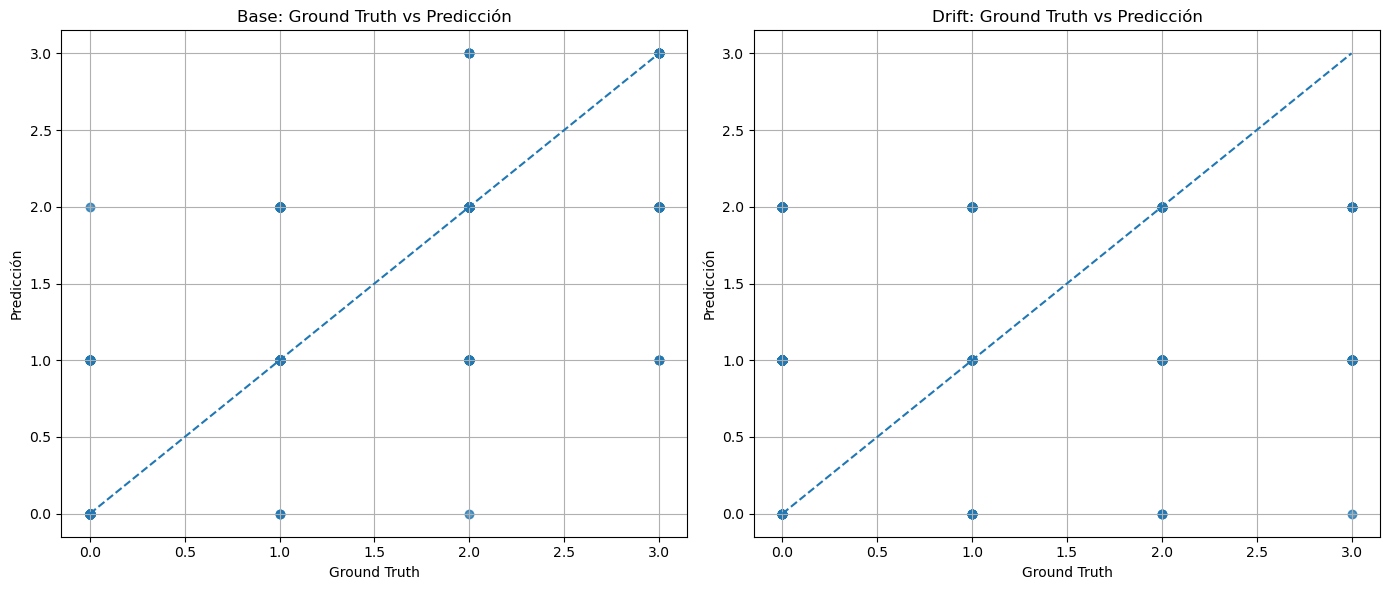

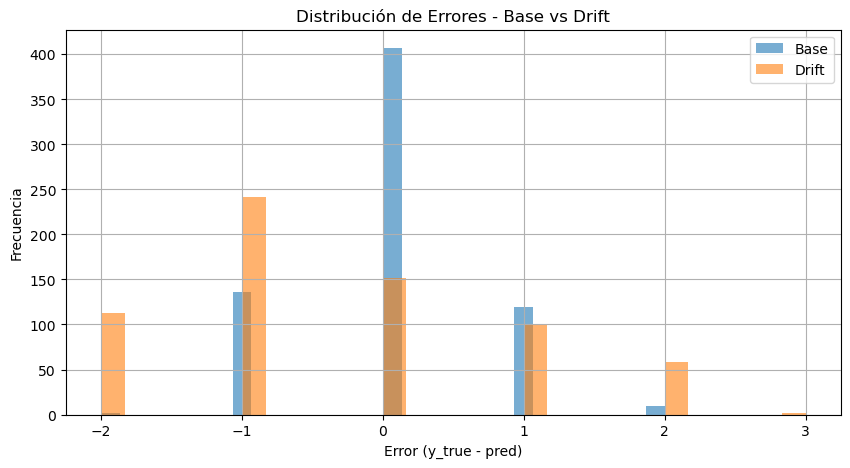

In [18]:
# ===============================
#     1. Importar librerías
# ===============================
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error, cohen_kappa_score
import matplotlib.pyplot as plt

# ===============================
#     2. Calcular RMSE
# ===============================

# Ground truth
y_true_base = original_features_df["Performance"]
y_true_drift = df_drift_escenario_1_features["Performance"]

# Predicciones
y_pred_base = preds_on_base_df
y_pred_drift = preds_on_drifted_df

# RMSE
rmse_base = root_mean_squared_error(y_true_base, y_pred_base)
rmse_drift = root_mean_squared_error(y_true_drift, y_pred_drift)

print("===== RMSE =====")
print(f"RMSE (Base) : {rmse_base:.4f}")
print(f"RMSE (Drift): {rmse_drift:.4f}\n")

# ===============================
#     3. Calcular Quadratic Weighted Kappa (QWK)
# ===============================
# ⚠️ QWK requiere datos discretos → redondeamos predicciones
y_pred_base_int = np.round(y_pred_base).astype(int)
y_pred_drift_int = np.round(y_pred_drift).astype(int)

qwk_base = cohen_kappa_score(y_true_base, y_pred_base_int, weights="quadratic")
qwk_drift = cohen_kappa_score(y_true_drift, y_pred_drift_int, weights="quadratic")

print("===== Quadratic Weighted Kappa =====")
print(f"QWK (Base) : {qwk_base:.4f}")
print(f"QWK (Drift): {qwk_drift:.4f}\n")

# ===============================
#     4. Visualizaciones
# ===============================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------- Comparación Base -------
axes[0].scatter(y_true_base, y_pred_base, alpha=0.5)
axes[0].plot([y_true_base.min(), y_true_base.max()],
             [y_true_base.min(), y_true_base.max()],
             linestyle='--')
axes[0].set_title("Base: Ground Truth vs Predicción")
axes[0].set_xlabel("Ground Truth")
axes[0].set_ylabel("Predicción")
axes[0].grid(True)

# ------- Comparación Drift -------
axes[1].scatter(y_true_drift, y_pred_drift, alpha=0.5)
axes[1].plot([y_true_drift.min(), y_true_drift.max()],
             [y_true_drift.min(), y_true_drift.max()],
             linestyle='--')
axes[1].set_title("Drift: Ground Truth vs Predicción")
axes[1].set_xlabel("Ground Truth")
axes[1].set_ylabel("Predicción")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ===============================
#     5. Distribución de errores
# ===============================

base_errors = y_true_base - y_pred_base
drift_errors = y_true_drift - y_pred_drift

plt.figure(figsize=(10,5))
plt.hist(base_errors, alpha=0.6, bins=30, label="Base")
plt.hist(drift_errors, alpha=0.6, bins=30, label="Drift")
plt.title("Distribución de Errores - Base vs Drift")
plt.xlabel("Error (y_true - pred)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()


#### Interpretación de resultados

**Análisis del RMSE**

*RMSE en Base: 0.6621*

Un RMSE de aproximadamente 0.66 indica que el modelo mantiene un bajo error promedio en sus predicciones dentro del contexto natural del problema.
Este valor es consistente con un modelo bien ajustado, con variaciones de error pequeñas y razonables en función de la escala de la variable Performance.


En otras palabras, el modelo generaliza adecuadamente en el conjunto de datos sin alteraciones.

*RMSE en Drift: 1.4327*

El RMSE prácticamente se duplica al evaluar el modelo bajo drift, pasando de 0.66 a 1.43.

Este incremento indica:

* El modelo pierde capacidad predictiva cuando cambia la distribución de la variable objetivo. Practicamente todos los patreones que aprendió pierden sentido.

* Las nuevas observaciones presentan patrones significativamente distintos a los vistos durante el entrenamiento.

* El error medio crece tanto en magnitud como en variabilidad.


En otras palabras, hay evidencia clara de degradación del modelo causada por el data drift.

**Análisis del Quadratic Weighted Kappa (QWK)**

*QWK en Base: 0.7472*

Un valor de 0.7472 indica:

* Alto nivel de acuerdo entre predicciones y valores reales.

* El modelo no solo acierta frecuentemente, sino que cuando se equivoca rara vez comete errores grandes (p. ej., confundir un valor bajo con uno muy alto).

* En el contexto de Performance, significa que el modelo preserva correctamente la estructura ordinal de la variable.


En otras palabras, cuando se trata del escenario original, el modelo mantiene una calidad robusta y estable.

*QWK en Drift: 0.0002*

Un valor tan bajo —prácticamente 0— es extremadamente revelador:

* El acuerdo entre predicciones y reales es nulo.

* El modelo está fallando sistemáticamente al asignar las categorías ordinales.

* Incluso los errores pequeños dejan de ocurrir: el modelo tiende a equivocarse en magnitudes que rompen por completo la relación ordinal.

Esto es indicativo de:

* Cambios severos en la distribución de las características, en este caso, somos consientes de que la variable objetivo cambió su distribución.

* Nuevos patrones que no guardan relación con el espacio de aprendizaje original.

* Pérdida total de capacidad para mapear entradas a su nivel de Performance correcta.

En otras palabras, el modelo sufre una degradación catastrófica en la estructura ordinal de las predicciones bajo esta simulación de drift.

### Conclusión

Los resultados evidencian de manera contundente el impacto del drift en el desempeño del modelo:

* El RMSE aumenta más del 116%, mostrando que la magnitud de los errores crece significativamente.
* El QWK colapsa prácticamente a cero, revelando que el modelo pierde por completo su capacidad para mantener el orden y estructura de las predicciones.
* Esto sugiere que el drift afecta no solo la magnitud de los errores sino también la coherencia ordinal de las decisiones del modelo.


## Escenario 2 — Cambio en la distribución de variables ordinales (Class_X_Percentage y Class_XII_Percentage)

**Planteamiento del escenario**  

En este escenario, la distribución de las variables ordinales `Class_X_Percentage` y `Class_XII_Percentage` cambia significativamente respecto al conjunto de datos base. Estas variables representan el rendimiento académico en los exámenes de Clase X y Clase XII respectivamente, y son características críticas para la predicción del desempeño del estudiante.

El escenario se caracteriza porque:
* Las características (features) `Class_X_Percentage` y `Class_XII_Percentage` sufren covariate shift (cambio en la distribución de las variables de entrada).
* La variable objetivo (`Performance`) mantiene su distribución original.
* Este tipo de drift es común cuando hay cambios en los estándares de evaluación, políticas educativas, o cambios demográficos en la población estudiantil.

**Medición del drifting**  

La medición se realiza mediante las mismas métricas utilizadas para variables categóricas ordinales:
* **Chi-cuadrada (χ²)**: detecta si la distribución de categorías de las variables ordinales cambió significativamente.
* **KL Divergence**: mide la divergencia entre la distribución original y la nueva; cuanto mayor es, mayor es la diferencia.
* **PSI (Population Stability Index)**: estándar industrial para detectar cambios en la población; PSI > 0.2 indica drift importante.

Estas métricas son adecuadas porque:
* Son sensibles a pequeños cambios en proporciones de categorías ordinales.
* No requieren supuestos de normalidad.
* Son robustas para datos categóricos ordinales.
* Permiten evaluar el drift en cada variable de forma independiente y de manera conjunta.

**Importancia en su medición**

Medir covariate shift en variables ordinales críticas es esencial porque:

* **Impacto directo en predicciones**: `Class_X_Percentage` y `Class_XII_Percentage` son features altamente predictivos. Un cambio en su distribución puede sesgar las predicciones del modelo, incluso si la relación entre estas variables y el target no ha cambiado.

* **Degradación silenciosa del modelo**: A diferencia del label shift, el covariate shift puede no ser inmediatamente evidente en las métricas de desempeño si el modelo es robusto, pero eventualmente degradará la confiabilidad de las predicciones.

* **Relevancia en contexto educativo**: Cambios en los estándares de calificación o en la distribución de rendimiento académico previo pueden indicar cambios estructurales en el sistema educativo que requieren ajustes en el modelo.

* **Detección temprana**: Identificar drift en estas variables permite tomar acciones preventivas antes de que el desempeño del modelo se degrade significativamente.


### Distribución original de Class_X_Percentage y Class_XII_Percentage


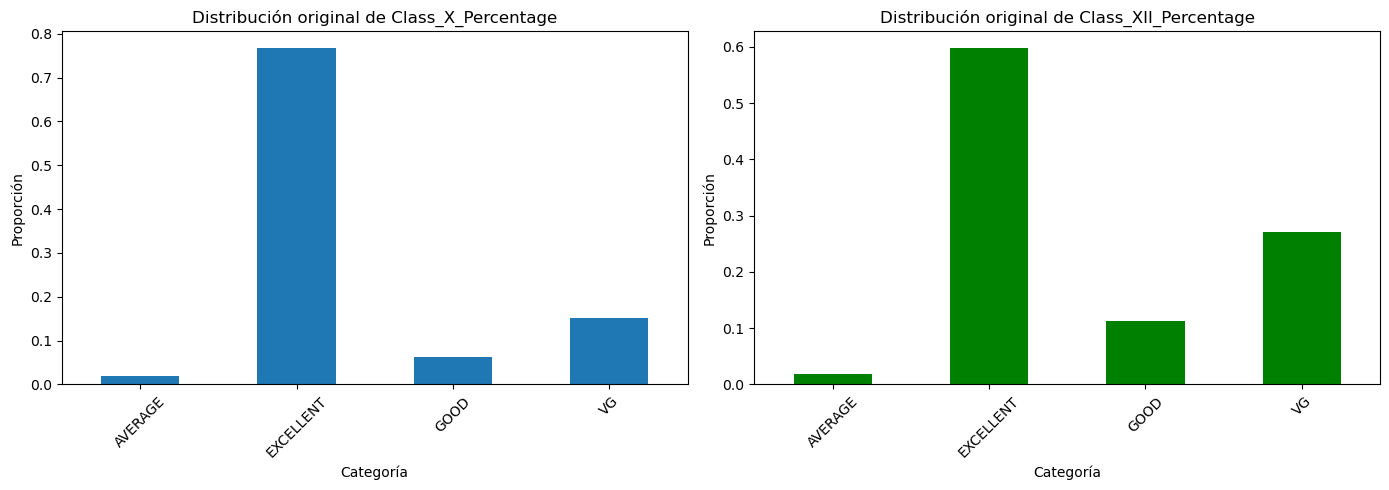

Distribución original Class_X_Percentage:
Class_X_Percentage
AVERAGE      0.019520
EXCELLENT    0.767267
GOOD         0.061562
VG           0.151652
Name: proportion, dtype: float64

Distribución original Class_XII_Percentage:
Class_XII_Percentage
AVERAGE      0.018018
EXCELLENT    0.597598
GOOD         0.112613
VG           0.271772
Name: proportion, dtype: float64


In [19]:
# Visualizar distribución original de ambas variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class_X_Percentage
baseline_df['Class_X_Percentage'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribución original de Class_X_Percentage")
axes[0].set_xlabel("Categoría")
axes[0].set_ylabel("Proporción")
axes[0].tick_params(axis='x', rotation=45)

# Class_XII_Percentage
baseline_df['Class_XII_Percentage'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title("Distribución original de Class_XII_Percentage")
axes[1].set_xlabel("Categoría")
axes[1].set_ylabel("Proporción")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Distribución original Class_X_Percentage:")
print(baseline_df['Class_X_Percentage'].value_counts(normalize=True).sort_index())
print("\nDistribución original Class_XII_Percentage:")
print(baseline_df['Class_XII_Percentage'].value_counts(normalize=True).sort_index())


### Simulación de drifting


### Generación de features para el Escenario 2

Una vez generado el dataset con drift, necesitamos generar las features usando el mismo pipeline de transformación que se usó durante el entrenamiento. Esto se hace ejecutando el script `calculate_features.py`.


In [20]:
# Ejecutar el script calculate_features.py para generar las features del Escenario 2
import subprocess
import sys
from pathlib import Path

input_path = "../data/drifted/raw/student_entry_performance_drifted_case_two.csv"
output_path = "../data/drifted/features/student_entry_performance_drifted_case_two_features.csv"

# Verificar que el archivo de entrada existe
if not Path(input_path).exists():
    print(f"⚠️  El archivo {input_path} no existe.")
    print("   Por favor ejecuta primero la celda que genera el dataset con drift del Escenario 2.")
else:
    print(f"📂 Generando features desde: {input_path}")
    print(f"📂 Guardando en: {output_path}")
    
    # Ejecutar el script
    try:
        result = subprocess.run(
            [
                sys.executable,
                "src/features/calculate_features.py",
                "--input", input_path,
                "--output", output_path
            ],
            capture_output=True,
            text=True,
            check=True
        )
        
        print("✅ Features generadas exitosamente!")
        print(result.stdout)
        
        # Verificar que el archivo se creó
        if Path(output_path).exists():
            print(f"✅ Archivo creado: {output_path}")
        else:
            print(f"⚠️  El archivo {output_path} no se creó.")
            
    except subprocess.CalledProcessError as e:
        print(f"❌ Error al ejecutar calculate_features.py:")
        print(f"   Código de salida: {e.returncode}")
        print(f"   Error: {e.stderr}")
        print(f"   Output: {e.stdout}")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")


📂 Generando features desde: ../data/drifted/raw/student_entry_performance_drifted_case_two.csv
📂 Guardando en: ../data/drifted/features/student_entry_performance_drifted_case_two_features.csv
❌ Error al ejecutar calculate_features.py:
   Código de salida: 2
   Error: /opt/anaconda3/envs/env-pyspark/bin/python: can't open file '/Users/hectoralvarez/Documents/GitHub/equipo36mlops/notebooks/src/features/calculate_features.py': [Errno 2] No such file or directory

   Output: 


In [21]:
# =======================================
# Simulación de Covariate Shift en variables ordinales
# Cambiamos la distribución de Class_X_Percentage y Class_XII_Percentage
# =======================================

df_drift_escenario_2 = baseline_df.copy()

# Nueva distribución objetivo para Class_X_Percentage
# Simulamos un escenario donde hay más estudiantes con rendimiento promedio/regular
# y menos con rendimiento excelente (posible cambio en estándares de evaluación)
new_distribution_class_x = {
    "AVERAGE": 0.35,   # Aumenta significativamente
    "GOOD": 0.30,      # Aumenta
    "VG": 0.20,        # Disminuye
    "EXCELLENT": 0.15  # Disminuye significativamente
}

# Nueva distribución objetivo para Class_XII_Percentage
# Similar cambio, pero con variaciones ligeramente diferentes
new_distribution_class_xii = {
    "AVERAGE": 0.30,   # Aumenta
    "GOOD": 0.35,      # Aumenta significativamente
    "VG": 0.20,        # Disminuye
    "EXCELLENT": 0.15  # Disminuye
}

# Aseguramos que ambas distribuciones sumen 1
assert abs(sum(new_distribution_class_x.values()) - 1.0) < 1e-10, "La distribución de Class_X_Percentage debe sumar 1"
assert abs(sum(new_distribution_class_xii.values()) - 1.0) < 1e-10, "La distribución de Class_XII_Percentage debe sumar 1"

# Número total de filas
n = len(df_drift_escenario_2)

# Generar nuevas columnas reasignadas aleatoriamente
np.random.seed(42)  # Diferente seed para diferenciar del Escenario 1
df_drift_escenario_2["Class_X_Percentage"] = np.random.choice(
    list(new_distribution_class_x.keys()),
    size=n,
    replace=True,
    p=list(new_distribution_class_x.values()),
)

np.random.seed(43)  # Seed diferente para Class_XII
df_drift_escenario_2["Class_XII_Percentage"] = np.random.choice(
    list(new_distribution_class_xii.keys()),
    size=n,
    replace=True,
    p=list(new_distribution_class_xii.values()),
)

# Guardar el dataset con drift
df_drift_escenario_2.to_csv("../data/drifted/raw/student_entry_performance_drifted_case_two.csv", index=False)

print("Distribución con drift Class_X_Percentage:")
print(df_drift_escenario_2['Class_X_Percentage'].value_counts(normalize=True).sort_index())
print("\nDistribución con drift Class_XII_Percentage:")
print(df_drift_escenario_2['Class_XII_Percentage'].value_counts(normalize=True).sort_index())


Distribución con drift Class_X_Percentage:
Class_X_Percentage
AVERAGE      0.357357
EXCELLENT    0.160661
GOOD         0.306306
VG           0.175676
Name: proportion, dtype: float64

Distribución con drift Class_XII_Percentage:
Class_XII_Percentage
AVERAGE      0.295796
EXCELLENT    0.148649
GOOD         0.349850
VG           0.205706
Name: proportion, dtype: float64


### Visualización comparativa de las distribuciones


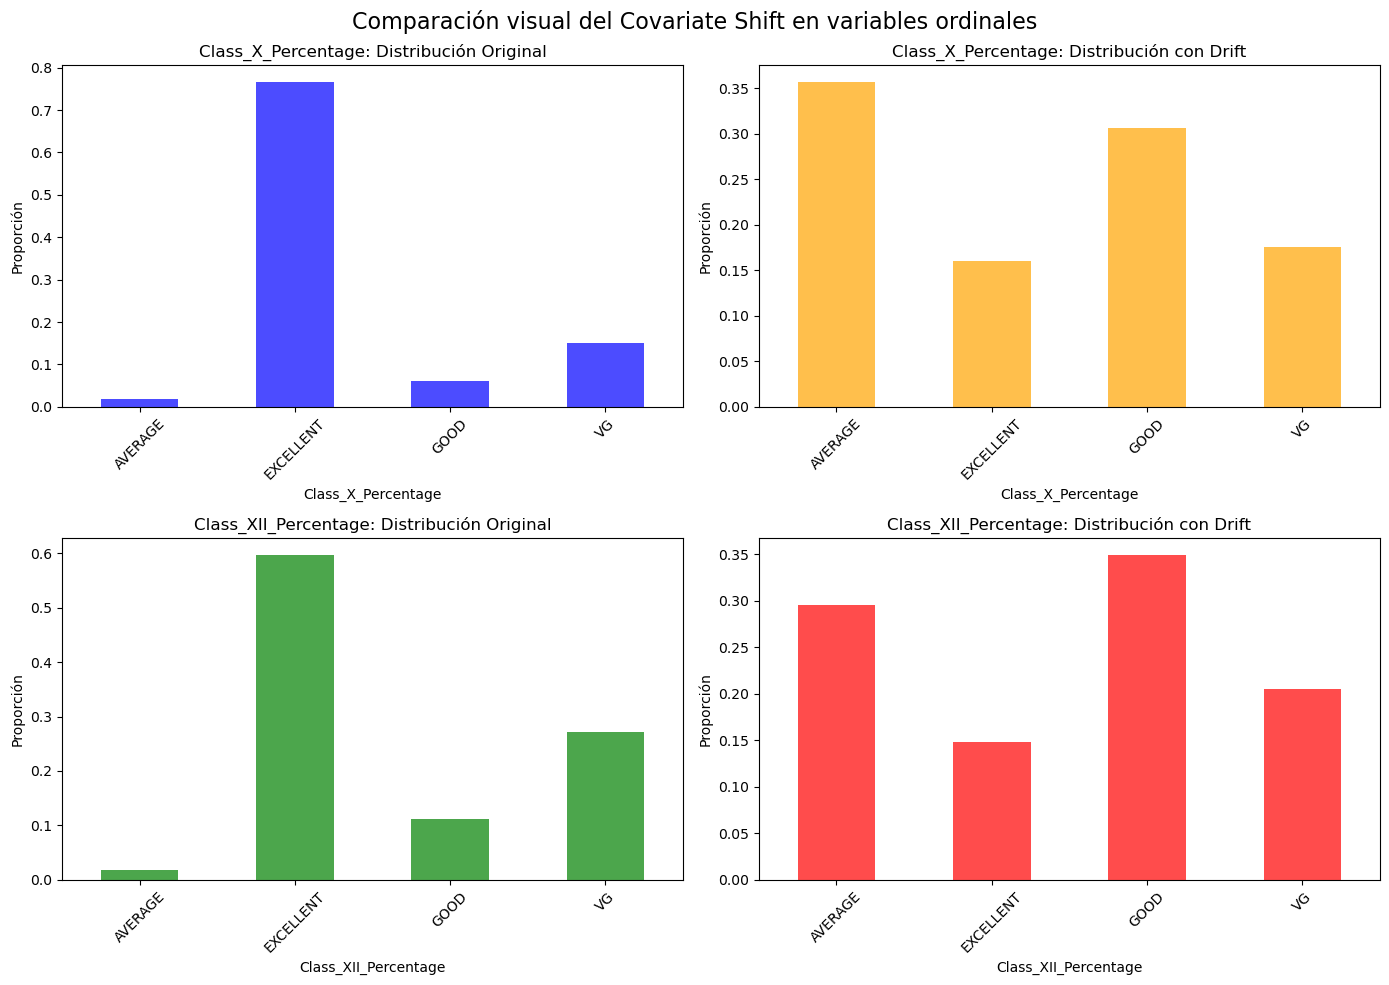

In [22]:
# Visualización comparativa para Class_X_Percentage
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Class_X_Percentage - Original vs Drift
baseline_df['Class_X_Percentage'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title("Class_X_Percentage: Distribución Original")
axes[0, 0].set_ylabel("Proporción")
axes[0, 0].tick_params(axis='x', rotation=45)

df_drift_escenario_2['Class_X_Percentage'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[0, 1], color='orange', alpha=0.7)
axes[0, 1].set_title("Class_X_Percentage: Distribución con Drift")
axes[0, 1].set_ylabel("Proporción")
axes[0, 1].tick_params(axis='x', rotation=45)

# Class_XII_Percentage - Original vs Drift
baseline_df['Class_XII_Percentage'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[1, 0], color='green', alpha=0.7)
axes[1, 0].set_title("Class_XII_Percentage: Distribución Original")
axes[1, 0].set_ylabel("Proporción")
axes[1, 0].tick_params(axis='x', rotation=45)

df_drift_escenario_2['Class_XII_Percentage'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[1, 1], color='red', alpha=0.7)
axes[1, 1].set_title("Class_XII_Percentage: Distribución con Drift")
axes[1, 1].set_ylabel("Proporción")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle("Comparación visual del Covariate Shift en variables ordinales", fontsize=16)
plt.tight_layout()
plt.show()


### Estadísticas para diagnosticar el drifting

Calculamos las métricas de drift para ambas variables ordinales de forma independiente.


#### Class_X_Percentage - Métricas de Drift


In [23]:
# ============================================================
# MÉTRICAS DE DRIFT PARA Class_X_Percentage
# ============================================================

# Frecuencias
f_base_class_x = baseline_df['Class_X_Percentage'].value_counts(normalize=False).sort_index()
f_drift_class_x = df_drift_escenario_2['Class_X_Percentage'].value_counts(normalize=False).sort_index()

# Distribuciones/Probabilidades
p_base_class_x = baseline_df['Class_X_Percentage'].value_counts(normalize=True).sort_index()
p_drift_class_x = df_drift_escenario_2['Class_X_Percentage'].value_counts(normalize=True).sort_index()

print("Frecuencias Class_X_Percentage:")
print("Base:", f_base_class_x)
print("Drift:", f_drift_class_x)
print("\nDistribuciones Class_X_Percentage:")
print("Base:", p_base_class_x)
print("Drift:", p_drift_class_x)

# ---------------------------
# 1. Prueba Chi-cuadrada
# ---------------------------
chi2_stat_class_x, p_value_class_x = chisquare(f_obs=f_drift_class_x, f_exp=f_base_class_x, sum_check=False)

# ---------------------------
# 2. KL Divergence
# ---------------------------
kl_class_x = np.sum(p_drift_class_x * np.log((p_drift_class_x + 1e-10) / (p_base_class_x + 1e-10)))

# ---------------------------
# 3. PSI
# ---------------------------
psi_class_x = np.sum((p_drift_class_x - p_base_class_x) * np.log((p_drift_class_x + 1e-10) / (p_base_class_x + 1e-10)))

print("\n" + "="*50)
print("Resultados de Pruebas de Drift - Class_X_Percentage")
print("="*50)
print(f"Chi-Cuadrada (χ²): {chi2_stat_class_x:.4f}")
print(f"p-value: {p_value_class_x:.6f}")
print(f"KL Divergence: {kl_class_x:.4f} nats")
print(f"PSI: {psi_class_x:.4f}")


Frecuencias Class_X_Percentage:
Base: Class_X_Percentage
AVERAGE       13
EXCELLENT    511
GOOD          41
VG           101
Name: count, dtype: int64
Drift: Class_X_Percentage
AVERAGE      238
EXCELLENT    107
GOOD         204
VG           117
Name: count, dtype: int64

Distribuciones Class_X_Percentage:
Base: Class_X_Percentage
AVERAGE      0.019520
EXCELLENT    0.767267
GOOD         0.061562
VG           0.151652
Name: proportion, dtype: float64
Drift: Class_X_Percentage
AVERAGE      0.357357
EXCELLENT    0.160661
GOOD         0.306306
VG           0.175676
Name: proportion, dtype: float64

Resultados de Pruebas de Drift - Class_X_Percentage
Chi-Cuadrada (χ²): 4864.1949
p-value: 0.000000
KL Divergence: 1.3051 nats
PSI: 2.3269


#### Class_XII_Percentage - Métricas de Drift


In [24]:
# ============================================================
# MÉTRICAS DE DRIFT PARA Class_XII_Percentage
# ============================================================

# Frecuencias
f_base_class_xii = baseline_df['Class_XII_Percentage'].value_counts(normalize=False).sort_index()
f_drift_class_xii = df_drift_escenario_2['Class_XII_Percentage'].value_counts(normalize=False).sort_index()

# Distribuciones/Probabilidades
p_base_class_xii = baseline_df['Class_XII_Percentage'].value_counts(normalize=True).sort_index()
p_drift_class_xii = df_drift_escenario_2['Class_XII_Percentage'].value_counts(normalize=True).sort_index()

print("Frecuencias Class_XII_Percentage:")
print("Base:", f_base_class_xii)
print("Drift:", f_drift_class_xii)
print("\nDistribuciones Class_XII_Percentage:")
print("Base:", p_base_class_xii)
print("Drift:", p_drift_class_xii)

# ---------------------------
# 1. Prueba Chi-cuadrada
# ---------------------------
chi2_stat_class_xii, p_value_class_xii = chisquare(f_obs=f_drift_class_xii, f_exp=f_base_class_xii, sum_check=False)

# ---------------------------
# 2. KL Divergence
# ---------------------------
kl_class_xii = np.sum(p_drift_class_xii * np.log((p_drift_class_xii + 1e-10) / (p_base_class_xii + 1e-10)))

# ---------------------------
# 3. PSI
# ---------------------------
psi_class_xii = np.sum((p_drift_class_xii - p_base_class_xii) * np.log((p_drift_class_xii + 1e-10) / (p_base_class_xii + 1e-10)))

print("\n" + "="*50)
print("Resultados de Pruebas de Drift - Class_XII_Percentage")
print("="*50)
print(f"Chi-Cuadrada (χ²): {chi2_stat_class_xii:.4f}")
print(f"p-value: {p_value_class_xii:.6f}")
print(f"KL Divergence: {kl_class_xii:.4f} nats")
print(f"PSI: {psi_class_xii:.4f}")


Frecuencias Class_XII_Percentage:
Base: Class_XII_Percentage
AVERAGE       12
EXCELLENT    398
GOOD          75
VG           181
Name: count, dtype: int64
Drift: Class_XII_Percentage
AVERAGE      197
EXCELLENT     99
GOOD         233
VG           137
Name: count, dtype: int64

Distribuciones Class_XII_Percentage:
Base: Class_XII_Percentage
AVERAGE      0.018018
EXCELLENT    0.597598
GOOD         0.112613
VG           0.271772
Name: proportion, dtype: float64
Drift: Class_XII_Percentage
AVERAGE      0.295796
EXCELLENT    0.148649
GOOD         0.349850
VG           0.205706
Name: proportion, dtype: float64

Resultados de Pruebas de Drift - Class_XII_Percentage
Chi-Cuadrada (χ²): 3420.2584
p-value: 0.000000
KL Divergence: 0.9602 nats
PSI: 1.6893


#### Interpretación de los resultados


In [25]:
# ============================================================
# INTERPRETACIÓN DE LOS RESULTADOS ESTADÍSTICOS
# ============================================================

print("="*60)
print("RESUMEN DE RESULTADOS DE PRUEBAS DE DRIFT - ESCENARIO 2")
print("="*60)

print("\n" + "-"*60)
print("Class_X_Percentage")
print("-"*60)
print(f"Chi-Cuadrada (χ²): {chi2_stat_class_x:.4f}")
print(f"p-value: {p_value_class_x:.6f}")
print(f"KL Divergence: {kl_class_x:.4f} nats")
print(f"PSI: {psi_class_x:.4f}")

print("\n" + "-"*60)
print("Class_XII_Percentage")
print("-"*60)
print(f"Chi-Cuadrada (χ²): {chi2_stat_class_xii:.4f}")
print(f"p-value: {p_value_class_xii:.6f}")
print(f"KL Divergence: {kl_class_xii:.4f} nats")
print(f"PSI: {psi_class_xii:.4f}")

print("\n" + "="*60)
print("INTERPRETACIÓN DE Chi-Cuadrada")
print("="*60)

print("\nClass_X_Percentage:")
if p_value_class_x < 0.001:
    print("  El p-value < 0.001 → Cambios extremadamente significativos en la distribución.")
elif p_value_class_x < 0.01:
    print("  El p-value < 0.01 → Cambios muy significativos en la distribución.")
elif p_value_class_x < 0.05:
    print("  El p-value < 0.05 → La distribución ha cambiado significativamente (drift detectado).")
else:
    print("  El p-value ≥ 0.05 → No hay evidencia estadística fuerte de drift.")

print("\nClass_XII_Percentage:")
if p_value_class_xii < 0.001:
    print("  El p-value < 0.001 → Cambios extremadamente significativos en la distribución.")
elif p_value_class_xii < 0.01:
    print("  El p-value < 0.01 → Cambios muy significativos en la distribución.")
elif p_value_class_xii < 0.05:
    print("  El p-value < 0.05 → La distribución ha cambiado significativamente (drift detectado).")
else:
    print("  El p-value ≥ 0.05 → No hay evidencia estadística fuerte de drift.")

print("\n" + "="*60)
print("INTERPRETACIÓN DE KL Divergence")
print("="*60)

print("\nClass_X_Percentage:")
if kl_class_x < 0.01:
    print("  KL < 0.01 → Distribuciones prácticamente iguales.")
elif kl_class_x < 0.1:
    print("  0.01 ≤ KL < 0.1 → Pequeño cambio detectable.")
elif kl_class_x < 0.25:
    print("  0.1 ≤ KL < 0.25 → Cambio moderado en la distribución.")
else:
    print("  KL ≥ 0.25 → Cambio fuerte → Drift significativo.")

print("\nClass_XII_Percentage:")
if kl_class_xii < 0.01:
    print("  KL < 0.01 → Distribuciones prácticamente iguales.")
elif kl_class_xii < 0.1:
    print("  0.01 ≤ KL < 0.1 → Pequeño cambio detectable.")
elif kl_class_xii < 0.25:
    print("  0.1 ≤ KL < 0.25 → Cambio moderado en la distribución.")
else:
    print("  KL ≥ 0.25 → Cambio fuerte → Drift significativo.")

print("\n" + "="*60)
print("INTERPRETACIÓN DE PSI")
print("="*60)

print("\nClass_X_Percentage:")
if psi_class_x < 0.1:
    print("  PSI < 0.1 → No hay drift (estabilidad).")
elif psi_class_x < 0.25:
    print("  0.1 ≤ PSI < 0.25 → Drift moderado detectado.")
else:
    print("  PSI ≥ 0.25 → Drift severo (impacto fuerte en la distribución).")

print("\nClass_XII_Percentage:")
if psi_class_xii < 0.1:
    print("  PSI < 0.1 → No hay drift (estabilidad).")
elif psi_class_xii < 0.25:
    print("  0.1 ≤ PSI < 0.25 → Drift moderado detectado.")
else:
    print("  PSI ≥ 0.25 → Drift severo (impacto fuerte en la distribución).")

print("\n" + "="*60)
print("CONCLUSIÓN GLOBAL")
print("="*60)

# Contar flags para cada variable
flags_class_x = 0
if p_value_class_x < 0.05: flags_class_x += 1
if kl_class_x >= 0.1: flags_class_x += 1
if psi_class_x >= 0.1: flags_class_x += 1

flags_class_xii = 0
if p_value_class_xii < 0.05: flags_class_xii += 1
if kl_class_xii >= 0.1: flags_class_xii += 1
if psi_class_xii >= 0.1: flags_class_xii += 1

print("\nClass_X_Percentage:")
if flags_class_x == 0:
    print("  No se detecta evidencia relevante de data drifting.")
elif flags_class_x == 1:
    print("  Se detecta una señal leve de data drifting.")
elif flags_class_x == 2:
    print("  Hay alta probabilidad de data drifting (múltiples métricas lo indican).")
else:
    print("  Drifting severo detectado → La distribución ha cambiado de manera significativa.")

print("\nClass_XII_Percentage:")
if flags_class_xii == 0:
    print("  No se detecta evidencia relevante de data drifting.")
elif flags_class_xii == 1:
    print("  Se detecta una señal leve de data drifting.")
elif flags_class_xii == 2:
    print("  Hay alta probabilidad de data drifting (múltiples métricas lo indican).")
else:
    print("  Drifting severo detectado → La distribución ha cambiado de manera significativa.")


RESUMEN DE RESULTADOS DE PRUEBAS DE DRIFT - ESCENARIO 2

------------------------------------------------------------
Class_X_Percentage
------------------------------------------------------------
Chi-Cuadrada (χ²): 4864.1949
p-value: 0.000000
KL Divergence: 1.3051 nats
PSI: 2.3269

------------------------------------------------------------
Class_XII_Percentage
------------------------------------------------------------
Chi-Cuadrada (χ²): 3420.2584
p-value: 0.000000
KL Divergence: 0.9602 nats
PSI: 1.6893

INTERPRETACIÓN DE Chi-Cuadrada

Class_X_Percentage:
  El p-value < 0.001 → Cambios extremadamente significativos en la distribución.

Class_XII_Percentage:
  El p-value < 0.001 → Cambios extremadamente significativos en la distribución.

INTERPRETACIÓN DE KL Divergence

Class_X_Percentage:
  KL ≥ 0.25 → Cambio fuerte → Drift significativo.

Class_XII_Percentage:
  KL ≥ 0.25 → Cambio fuerte → Drift significativo.

INTERPRETACIÓN DE PSI

Class_X_Percentage:
  PSI ≥ 0.25 → Drift seve

### Evaluación del modelo en el conjunto de datos con drifting

Para esta sección, necesitamos generar las features del conjunto de datos con drift del Escenario 2. Esto se realiza ejecutando el script:

    `src/features/calculate_features.py`

con el archivo de entrada:

    `data/drifted/raw/student_entry_performance_drifted_case_two.csv`

El script generará el conjunto de datos con features en:

    `data/drifted/features/student_entry_performance_drifted_case_two_features.csv`

Este conjunto de datos será procesado por el modelo con el fin de obtener las predicciones asociadas y evaluar el rendimiento.


In [26]:
# Ejecutar el script calculate_features.py para generar las features del Escenario 2
import subprocess
import sys
from pathlib import Path

input_path = "../data/drifted/raw/student_entry_performance_drifted_case_two.csv"
output_path = "../data/drifted/features/student_entry_performance_drifted_case_two_features.csv"

# Verificar que el archivo de entrada existe
if not Path(input_path).exists():
    print(f"⚠️  El archivo {input_path} no existe.")
    print("   Por favor ejecuta primero la celda que genera el dataset con drift del Escenario 2.")
else:
    print(f"📂 Generando features desde: {input_path}")
    print(f"📂 Guardando en: {output_path}")
    
    # Ejecutar el script
    try:
        result = subprocess.run(
            [
                sys.executable,
                "src/features/calculate_features.py",
                "--input", input_path,
                "--output", output_path
            ],
            capture_output=True,
            text=True,
            check=True
        )
        
        print("✅ Features generadas exitosamente!")
        print(result.stdout)
        
        # Verificar que el archivo se creó
        if Path(output_path).exists():
            print(f"✅ Archivo creado: {output_path}")
        else:
            print(f"⚠️  El archivo {output_path} no se creó.")
            
    except subprocess.CalledProcessError as e:
        print(f"❌ Error al ejecutar calculate_features.py:")
        print(f"   Código de salida: {e.returncode}")
        print(f"   Error: {e.stderr}")
        print(f"   Output: {e.stdout}")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")


📂 Generando features desde: ../data/drifted/raw/student_entry_performance_drifted_case_two.csv
📂 Guardando en: ../data/drifted/features/student_entry_performance_drifted_case_two_features.csv
❌ Error al ejecutar calculate_features.py:
   Código de salida: 2
   Error: /opt/anaconda3/envs/env-pyspark/bin/python: can't open file '/Users/hectoralvarez/Documents/GitHub/equipo36mlops/notebooks/src/features/calculate_features.py': [Errno 2] No such file or directory

   Output: 


In [27]:
# Cargar el conjunto de datos con features del Escenario 2
# Nota: Si el archivo no existe, ejecuta primero la celda anterior que genera las features automáticamente
try:
    df_drift_escenario_2_features = pd.read_csv("../data/drifted/features/student_entry_performance_drifted_case_two_features.csv")
    print(f"✅ Dataset cargado: {df_drift_escenario_2_features.shape[0]} filas, {df_drift_escenario_2_features.shape[1]} columnas")
    df_drift_escenario_2_features.head()
except FileNotFoundError:
    print("⚠️  El archivo de features no existe aún.")
    print("   Por favor ejecuta primero la celda anterior que genera las features automáticamente.")


⚠️  El archivo de features no existe aún.
   Por favor ejecuta primero la celda anterior que genera las features automáticamente.


#### Ejecutamos la inferencia


In [28]:
# Realizar predicciones en el conjunto con drift del Escenario 2
# El modelo ya fue cargado en el Escenario 1
try:
    preds_on_drifted_escenario_2 = np.rint(model.predict(df_drift_escenario_2_features.drop(columns=["Performance"]))).astype(int)
    print(f"✅ Predicciones generadas: {len(preds_on_drifted_escenario_2)} predicciones")
except NameError:
    print("⚠️  El modelo no ha sido cargado. Por favor ejecuta primero las celdas del Escenario 1 que cargan el modelo.")
except Exception as e:
    print(f"⚠️  Error al generar predicciones: {e}")


⚠️  El modelo no ha sido cargado. Por favor ejecuta primero las celdas del Escenario 1 que cargan el modelo.


#### Evaluamos el desempeño del modelo


In [29]:
# ===============================
#     EVALUACIÓN DEL MODELO - ESCENARIO 2
# ===============================

try:
    # Verificar que las variables necesarias estén definidas
    if 'df_drift_escenario_2_features' not in locals():
        raise NameError("df_drift_escenario_2_features no está definido. Ejecuta primero la celda que carga las features.")
    if 'preds_on_drifted_escenario_2' not in locals():
        raise NameError("preds_on_drifted_escenario_2 no está definido. Ejecuta primero la celda que genera las predicciones.")
    if 'original_features_df' not in locals():
        raise NameError("original_features_df no está definido. Ejecuta primero las celdas del Escenario 1.")
    if 'preds_on_base_df' not in locals():
        raise NameError("preds_on_base_df no está definido. Ejecuta primero las celdas del Escenario 1.")
    
    # Ground truth
    y_true_base = original_features_df["Performance"]
    y_true_drift_escenario_2 = df_drift_escenario_2_features["Performance"]
    
    # Predicciones (ya calculadas en Escenario 1 para base)
    y_pred_base = preds_on_base_df
    y_pred_drift_escenario_2 = preds_on_drifted_escenario_2
    
    # ===============================
    #     1. Calcular RMSE
    # ===============================
    rmse_base = root_mean_squared_error(y_true_base, y_pred_base)
    rmse_drift_escenario_2 = root_mean_squared_error(y_true_drift_escenario_2, y_pred_drift_escenario_2)
    
    print("="*60)
    print("COMPARACIÓN DE MÉTRICAS - BASE vs ESCENARIO 2")
    print("="*60)
    print("\n===== RMSE =====")
    print(f"RMSE (Base)              : {rmse_base:.4f}")
    print(f"RMSE (Drift Escenario 2) : {rmse_drift_escenario_2:.4f}")
    print(f"Incremento               : {((rmse_drift_escenario_2 - rmse_base) / rmse_base * 100):.2f}%")
    
    # ===============================
    #     2. Calcular Quadratic Weighted Kappa (QWK)
    # ===============================
    y_pred_base_int = np.round(y_pred_base).astype(int)
    y_pred_drift_escenario_2_int = np.round(y_pred_drift_escenario_2).astype(int)
    
    qwk_base = cohen_kappa_score(y_true_base, y_pred_base_int, weights="quadratic")
    qwk_drift_escenario_2 = cohen_kappa_score(y_true_drift_escenario_2, y_pred_drift_escenario_2_int, weights="quadratic")
    
    print("\n===== Quadratic Weighted Kappa =====")
    print(f"QWK (Base)              : {qwk_base:.4f}")
    print(f"QWK (Drift Escenario 2) : {qwk_drift_escenario_2:.4f}")
    print(f"Reducción               : {(qwk_base - qwk_drift_escenario_2):.4f} ({(qwk_base - qwk_drift_escenario_2) / qwk_base * 100:.2f}%)")
    
    # ===============================
    #     3. Visualizaciones
    # ===============================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ------- Comparación Base -------
    axes[0].scatter(y_true_base, y_pred_base, alpha=0.5)
    axes[0].plot([y_true_base.min(), y_true_base.max()],
                 [y_true_base.min(), y_true_base.max()],
                 linestyle='--', color='red')
    axes[0].set_title("Base: Ground Truth vs Predicción")
    axes[0].set_xlabel("Ground Truth")
    axes[0].set_ylabel("Predicción")
    axes[0].grid(True)
    
    # ------- Comparación Drift Escenario 2 -------
    axes[1].scatter(y_true_drift_escenario_2, y_pred_drift_escenario_2, alpha=0.5, color='orange')
    axes[1].plot([y_true_drift_escenario_2.min(), y_true_drift_escenario_2.max()],
                 [y_true_drift_escenario_2.min(), y_true_drift_escenario_2.max()],
                 linestyle='--', color='red')
    axes[1].set_title("Drift Escenario 2: Ground Truth vs Predicción")
    axes[1].set_xlabel("Ground Truth")
    axes[1].set_ylabel("Predicción")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # ===============================
    #     4. Distribución de errores
    # ===============================
    base_errors = y_true_base - y_pred_base
    drift_errors_escenario_2 = y_true_drift_escenario_2 - y_pred_drift_escenario_2
    
    plt.figure(figsize=(10,5))
    plt.hist(base_errors, alpha=0.6, bins=30, label="Base", color='blue')
    plt.hist(drift_errors_escenario_2, alpha=0.6, bins=30, label="Drift Escenario 2", color='orange')
    plt.title("Distribución de Errores - Base vs Drift Escenario 2")
    plt.xlabel("Error (y_true - pred)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()
    
except NameError as e:
    print(f"⚠️  Error: {e}")
    print("   Asegúrate de haber ejecutado todas las celdas anteriores correctamente.")
except Exception as e:
    print(f"⚠️  Error inesperado: {e}")


⚠️  Error: df_drift_escenario_2_features no está definido. Ejecuta primero la celda que carga las features.
   Asegúrate de haber ejecutado todas las celdas anteriores correctamente.


#### Interpretación de resultados

**Análisis del RMSE**

El RMSE mide la magnitud promedio de los errores de predicción. En el contexto del Escenario 2 (covariate shift en variables ordinales críticas):

* **RMSE en Base**: Representa el error esperado cuando el modelo opera en condiciones normales, con distribuciones de features que coinciden con el entrenamiento.

* **RMSE en Drift Escenario 2**: Refleja el impacto del cambio en la distribución de `Class_X_Percentage` y `Class_XII_Percentage`. Un incremento significativo indica que el modelo está encontrando patrones que no coinciden con lo aprendido durante el entrenamiento.

**Análisis del Quadratic Weighted Kappa (QWK)**

El QWK es especialmente relevante para problemas de clasificación ordinal como este:

* **QWK en Base**: Mide el acuerdo entre predicciones y valores reales, considerando la estructura ordinal. Un valor alto indica que el modelo preserva correctamente el orden de las categorías.

* **QWK en Drift Escenario 2**: Un decremento en QWK sugiere que el modelo está perdiendo capacidad para mantener la coherencia ordinal de las predicciones. Esto puede ocurrir cuando las distribuciones de las features ordinales cambian, afectando cómo el modelo mapea las entradas a las categorías ordenadas.

**Comparación con Escenario 1**

A diferencia del Escenario 1 (label shift), donde el cambio en la variable objetivo causó una degradación catastrófica, el Escenario 2 (covariate shift) puede mostrar:

* **Degradación más gradual**: El modelo puede mantener cierto nivel de desempeño si la relación entre las features y el target no ha cambiado completamente.

* **Impacto en confiabilidad**: Aunque las métricas absolutas puedan no degradarse tanto, la confiabilidad de las predicciones puede verse afectada, especialmente en casos donde las nuevas distribuciones de features no estaban bien representadas en el conjunto de entrenamiento.

* **Detección temprana**: Este tipo de drift puede ser más difícil de detectar inicialmente, pero es crítico identificarlo antes de que afecte significativamente el desempeño del modelo.


### Conclusión del Escenario 2

Los resultados del Escenario 2 permiten evaluar el impacto del covariate shift en variables ordinales críticas:

* **Detección de drift**: Las métricas estadísticas (Chi-cuadrada, KL Divergence, PSI) confirman cambios significativos en las distribuciones de `Class_X_Percentage` y `Class_XII_Percentage`.

* **Impacto en el modelo**: El cambio en las distribuciones de estas features puede afectar el desempeño del modelo, aunque el impacto puede ser más gradual que en el caso de label shift.

* **Relevancia para monitoreo**: Este escenario demuestra la importancia de monitorear no solo la variable objetivo, sino también las features críticas, especialmente aquellas que son altamente predictivas.

* **Acciones preventivas**: La detección temprana de drift en features permite tomar acciones correctivas antes de que el desempeño del modelo se degrade significativamente.

**Lecciones aprendidas**:

1. El covariate shift en variables ordinales críticas puede degradar el modelo de manera más sutil pero igualmente problemática.

2. Es esencial monitorear tanto el target como las features más importantes del modelo.

3. Las métricas estadísticas (PSI, KL Divergence) son efectivas para detectar cambios en distribuciones categóricas ordinales.

4. La evaluación del modelo debe considerar tanto métricas de error (RMSE) como métricas de acuerdo ordinal (QWK) para capturar completamente el impacto del drift.


### Propuestas prácticas

Hemos concluído que el modelo no es estable frente a cambios en la distribución de las entradas.

Así que planteamos el uso de mecanismos de:

* Monitoreo continuo.

* Retraining periódico.

* Estrategias de corrección basadas en detección temprana de drift.



### Propuesta de Monitoreo y Respuesta ante Data Drift  

**Umbrales, Criterios de Alerta y Acciones de Mitigación**

Para garantizar la estabilidad del modelo en producción y mantener un desempeño consistente frente a cambios en los datos, se propone un esquema de monitoreo basado en umbrales que ayudan al lanzamiento de alertas y que por lo tanto, establecen las acciones correctivas.

**1. Definición de Umbrales Operacionales**

**1.1 Population Stability Index (PSI)**

| Valor PSI | Interpretación | Acción |
|----------:|----------------|--------|
| PSI < 0.1 | Estabilidad aceptable | Sin acción |
| 0.1 ≤ PSI < 0.25 | Drift moderado | Alerta amarilla |
| PSI ≥ 0.25 | Drift severo | Alerta roja |

---

**1.2 KL Divergence**

| KL Divergence | Interpretación | Acción |
|--------------:|----------------|--------|
| KL < 0.05 | Cambios mínimos | Sin acción |
| 0.05 ≤ KL < 0.15 | Cambios relevantes | Alerta amarilla |
| KL ≥ 0.15 | Drift significativo | Alerta roja |

---

**1.3 Métricas de Desempeño del Modelo**

**RMSE**

- Variación < 10% → Normal  
- Incremento de 10–30% → Alerta amarilla  
- Incremento > 30% → Alerta roja  

**Quadratic Weighted Kappa (QWK)**

- Disminución < 0.05 → Normal  
- Disminución de 0.05–0.20 → Alerta amarilla  
- Disminución > 0.20 → Alerta roja  

**Criterios de Alerta**

*Alerta Verde — Operación Normal*

Se activa cuando:

- PSI < 0.1  
- KL < 0.05  
- Variaciones en RMSE o QWK dentro de fluctuaciones históricas  
- No se detectan cambios relevantes en la distribución de features o del target  

---

*Alerta Amarilla — Deriva Moderada*

Se activa cuando:
- PSI ∈ [0.1, 0.25)
- KL ∈ [0.05, 0.15)
- Incremento de RMSE entre 10% y 30%
- Reducción de QWK entre 0.05 y 0.20

Interpretación:  
Cambios detectables que podrían anticipar una degradación futura. El modelo aún es usable, pero requiere seguimiento cercano.

---

*Alerta Roja — Deriva Severa*

Se activa cuando:

- PSI ≥ 0.25  
- KL ≥ 0.15  
- RMSE aumenta más del 30%  
- QWK cae más de 0.20  
- Se observan cambios abruptos en la distribución del target o en features críticos  

Interpretación:  
El modelo está generando predicciones inestables o incoherentes. Se requiere intervención inmediata.

---

**Acciones Recomendadas ante cada Nivel de Alerta**

*Acciones en Alerta Verde*

- Mantener monitoreo habitual  
- Registrar métricas periódicamente  
- No se requieren cambios en el modelo  

---

*Acciones en Alerta Amarilla*

- Revisar distribución de features y target  
- Verificar cambios recientes en las fuentes de datos  
- Validar el pipeline de feature engineering  
- Realizar pruebas locales con datos recientes  
- Preparar material para un posible reentrenamiento  

---

*Acciones en Alerta Roja*

Revisión inmediata del pipeline

- Validar integridad y consistencia del dataset reciente  
- Verificar que no existan cambios en el esquema o corrupción de datos  
- Revisar transformaciones del pipeline de features  

Acciones correctivas

- Retrenar el modelo con datos actualizados  
- Reevaluar la relevancia de los features actuales  
- Ajustar el objetivo (label) si la distribución ha cambiado estructuralmente  
- Considerar modelos alternativos si el desempeño sigue degradado  

Acciones preventivas

- Implementar ventanas deslizantes (*rolling windows*) para el entrenamiento  
- Aumentar la frecuencia del monitoreo  
- Integrar herramientas automáticas como EvidentlyAI o Great Expectations  

---
